In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install python_speech_features

  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


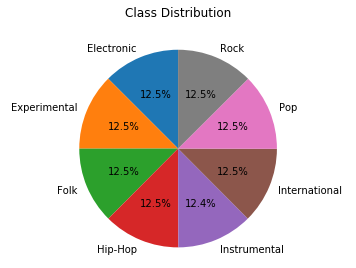

Loading existing data for time model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 9, 128)            72704     
_________________________________________________________________
lstm_6 (LSTM)                (None, 9, 128)            131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 9, 16)             528       
_________________________________________________________________
time_distributed_12 (TimeDis (None, 9, 

In [0]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, Reshape, Permute
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint



#change tp conv if shit

class Config:
    def __init__(self, mode='time', nfilt=26, nfeat = 13, nfft = 512, rate = 16000): #filtered out
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.rate = rate
        self.nfft = nfft
        self.step = int(rate/10) #0.1 sec, how much data computing while creating window
        self.model_path = os.path.join('/content/gdrive/My Drive/models', mode + '.model') 
        self.p_path = os.path.join('/content/gdrive/My Drive/pickles', mode + '.p')


def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)#load pickle file
            return tmp
    else:
        return None

def build_rand_feat():#preprocess to push
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min,_max = float('inf'), -float('inf') #to normalise input between 0 and 1
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p = prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)#pick random file from class, filename set to index
        rate, wav = wavfile.read('/content/gdrive/My Drive/clean/'+file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step] #a 1/10 of sec after
        X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt = config.nfilt, nfft = config.nfft)
        _min = min(np.amin(X_sample),_min)#grab a min from matrix
        _max = max(np.amax(X_sample),_max)
        #X.append(X_sample if config.mode =='conv' else X_sample.T) #shape of data..
        X.append(X_sample)
        y.append(classes.index(label)) #encode into ints, encode into values between 0 and 9
    config.min = _min
    config.max = _max
    X,y = np.array(X), np.array(y)
    X = (X- _min)/(_max - _min) #normalising value between 0 and 1
    if config.mode == 'convtime':
        X=X.reshape(X.shape[0], X.shape[1], X.shape[2],1) # 1 - greyscale for cnn
    elif config.mode == 'time': #rnn
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    elif config.mode == 'conv':
        X=X.reshape(X.shape[0], X.shape[1], X.shape[2],1) # 1 - greyscale for cnn
    y = to_categorical(y, num_classes=10)#categorical class enthropy, hot encoding variables
    config.data = (X, y)

    with open(config.p_path, 'wb') as handle:
        pickle.dump(config,handle,protocol=2)
    
    return X,y    
    
def get_convtime_model(): #convo layer - > pooling(once because 13x9) -> dence layers
    #model = Sequential()
    #model.add(Conv2D(16, (3,3), activation = 'relu', strides = (1,1),padding='same', input_shape = input_shape)) 
    #model.add(Conv2D(32, (3,3), activation = 'relu', strides = (1,1), padding = 'same')) #more filters, 3 3
    #model.add(Conv2D(64, (3,3), activation = 'relu', strides = (1,1), padding = 'same')) #more filters, 3 3
    #model.add(Conv2D(128, (3,3), activation = 'relu', strides = (1,1), padding = 'same')) #more filters, 3 3 
    #model.add(MaxPool2D((2,2)))
    #model.add(Dropout(0.5))#before flattening
    #model.add(Flatten())
    #model.add(Dense(256, activation = 'relu'))
    #model.add(Dense(10, activation = 'softmax')) #10 class activations, softmax - because categorical cross enthropy
    #model.summary()
    #model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
    #return model
    model = Sequential()
    #model.add(Conv2D(16, (3,3), activation = 'relu', strides = (1,1),padding='same', input_shape = input_shape))
    model.add(Conv2D(16, 3, strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32, 3, strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(64, 3, strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(128, 3, strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Reshape((128, -1)))
    model.add(Permute((2, 1)))
    model.add(LSTM(128, return_sequences = True, input_shape=input_shape)) #like a dense layer - long short memory model. 128 neurons shape of data n x 9 x 13
    model.add(LSTM(128, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu'))) #64 neurons
    model.add(TimeDistributed(Dense(8, activation='relu')))#time distrib => multiples by time => gotta bring it down
    model.add(Flatten())
    model.add(Dense(10, activation = 'softmax'))
    model.summary()
    model.load_weights("/content/gdrive/My Drive/models/conv.model")
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
    return model



def get_conv_model(): #convo layer - > pooling(once because 13x9) -> dence layers
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation = 'relu', strides = (1,1),padding='same', input_shape = input_shape)) 
    model.add(Conv2D(32, (3,3), activation = 'relu', strides = (1,1), padding = 'same')) #more filters, 3 3
    model.add(Conv2D(64, (3,3), activation = 'relu', strides = (1,1), padding = 'same')) #more filters, 3 3
    model.add(Conv2D(128, (3,3), activation = 'relu', strides = (1,1), padding = 'same')) #more filters, 3 3 
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))#before flattening
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dense(10, activation = 'softmax')) #10 class activations, softmax - because categorical cross enthropy
    model.summary()
    model.load_weights("/content/gdrive/My Drive/models/conv.model")
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
    return model


def get_recurrent_model():
    #shape of data for RNN is (n, time, feat) = n x 9 x 13
    model = Sequential()
    model.add(LSTM(128, return_sequences = True, input_shape=input_shape)) #like a dense layer - long short memory model. 128 neurons shape of data n x 9 x 13
    model.add(LSTM(128, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu'))) #64 neurons
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))#time distrib => multiples by time => gotta bring it down
    model.add(Flatten())
    model.add(Dense(10, activation = 'softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
    return model
   
        
#class Config:
#    def __init__(self, mode='conv', nfilt=26, nfeat = 13, nfft = 512, rate = 16000): #filtered out
#        self.mode = mode
#        self.nfilt = nfilt
#        self.nfeat = nfeat
#        self.rate = rate
#        self.nfft = nfft
#        self.step = int(rate/10) #0.1 sec, how much data computing while creating window

df = pd.read_csv('/content/gdrive/My Drive/instrumentswav1000.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read('/content/gdrive/My Drive/clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

#take a sec chunk outta data, random samples

n_samples = 2*int(df['length'].sum()/0.1) #all data
prob_dist = class_dist/class_dist.sum() #probability distribution, how many % of some class
choices = np.random.choice(class_dist.index, p=prob_dist)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()


config = Config(mode='time')

if config.mode == 'convtime':
    X, y = build_rand_feat()#features from random chunk
    y_flat = np.argmax(y, axis = 1)#return to original state (map back)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_convtime_model()
    model.load_weights("/content/gdrive/My Drive/models/convtime.model")
    
elif config.mode == 'time':
    X,y = build_rand_feat()
    y_flat = np.argmax(y, axis = 1)#return to original state (map back)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    model.load_weights("/content/gdrive/My Drive/models/time.model")

elif config.mode == 'conv':
    X, y = build_rand_feat()#features from random chunk
    y_flat = np.argmax(y, axis = 1)#return to original state (map back)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
    model.load_weights("/content/gdrive/My Drive/models/conv.model")
 


class_weight = compute_class_weight('balanced',np.unique(y_flat), y_flat)#to fix a bit input unbalance

checkpoint = ModelCheckpoint(config.model_path, monitor = 'val_acc', verbose = 2, mode = 'max', save_best_only = True, save_weights_only = False, period = 1) #update if better

model.fit(X, y, epochs = 50, batch_size=32, shuffle = True, validation_split = 0.1, callbacks = [checkpoint]) #creating batches of data

model.save(config.model_path) 
#class_weight was there
#val.split is last 10% of data for validation(shuffle. don't forget or else it would be crap)

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17081412533744157066, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10692415475559207824
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15519812663479817761
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10949587764
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5780617942880724640
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]